# Assignment 1 Part 1

## Task 1

In [1]:
#importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_formats = 'retina'
import os
import tensorflow as tf
import keras
import a1
from tensorflow.keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Input, Flatten, Dense, Dropout

In [2]:
#defining numpy image array
image = np.array([[[250,   2,   2], [  0, 255,   2], [  0,   0, 255]],
                  [[  2,  20,  20], [250, 255, 255], [127, 127, 127]]])   

In [3]:
#Checking height|width/row|col
rows, cols = image.shape[:2]
print(rows)
print(cols)

2
3


In [4]:
#Checking 1st example
light_pixels = a1.light_pixels(image, 20, 'red')
light_pixels

array([[1, 0, 0],
       [0, 1, 1]])

In [5]:
#Checking 2nd example
light_pixels = a1.light_pixels(image, 20, 'green')
light_pixels

array([[0, 1, 0],
       [0, 1, 1]])

In [6]:
#Checking 3rd example
light_pixels = a1.light_pixels(image, 15, 'blue')
light_pixels

array([[0, 0, 1],
       [1, 1, 1]])

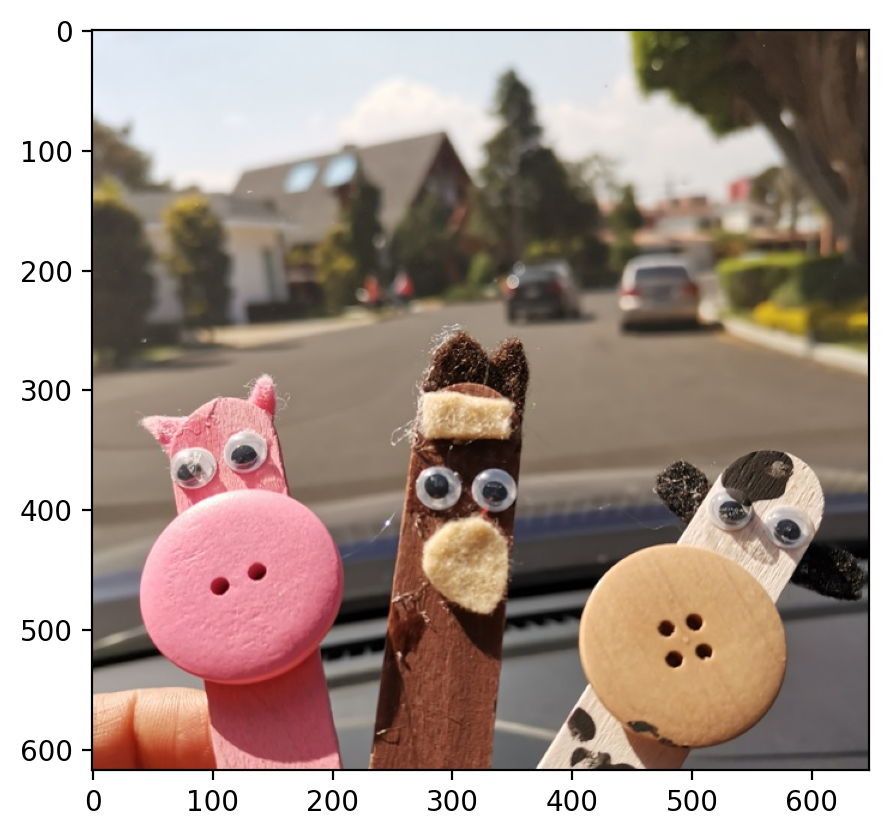

In [7]:
#importing stick_animals image with plt
stick_animal = plt.imread('stickanimals.jpg')
plt.imshow(stick_animal)

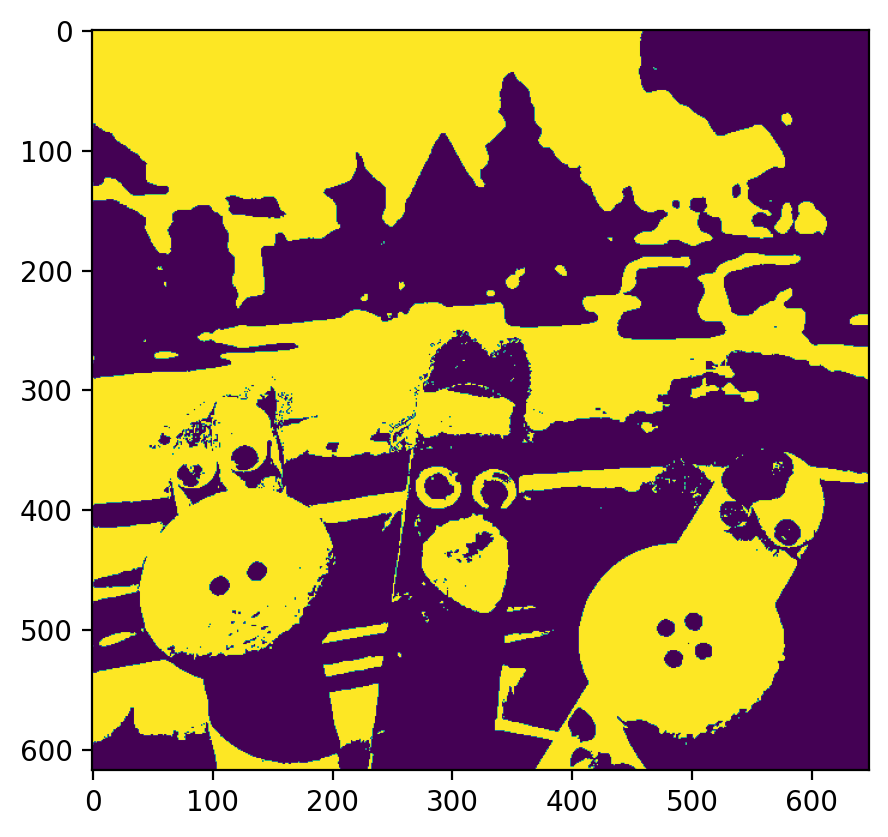

In [8]:
#Passing the image to the light_pixels function
light_pixels = a1.light_pixels(stick_animal, 127, 'green')
#Displaying modified image
plt.imshow(light_pixels)

## Task 2

In [12]:
# Example usage:
image = np.array([[[250,   2,   2], [  0,   2, 255], [  0,   0, 255]], 
                  [[  2,   2,  20], [250, 255, 255], [127, 127, 127]]])

print("Red channel histogram with 4 buckets:", a1.histogram(image, 4, 'red'))
print("Green channel histogram with 5 buckets:", a1.histogram(image, 5, 'green'))
print("Blue channel histogram with 6 buckets:", a1.histogram(image, 6, 'blue'))


Red channel histogram with 4 buckets: [3, 1, 0, 2]
Green channel histogram with 5 buckets: [4, 0, 1, 0, 1]
Blue channel histogram with 6 buckets: [2, 0, 0, 1, 0, 3]


## Task 3

In [68]:
# Example usage:
rows = 28
columns = 28
channels = 2
layer_options = [
    (128, 'relu', 0.2),  # 128 neurons, relu activation, 20% dropout
    (64, 'relu', 0),     # 64 neurons, relu activation, no dropout
    (32, 'sigmoid', 0.4) # 32 neurons, sigmoid activation, 40% dropout
]
model = a1.build_deep_nn(rows, columns, channels, layer_options)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 1568)              0         
                                                                 
 dense_2 (Dense)             (None, 128)               200832    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 64)                8256      
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
Total params: 211,168
Trainable params: 211,168
Non-tr

# Part 2

One of the questions of part 1 asks you to implement a function build_deep_nn. In this part of the assignment, write a Jupyter notebook a1.ipynb that trains and evaluates a deep learning classifier on the MNIST dataset. The notebook must call the function build_deep_nn that you have defined in file a1.py in order to build the deep learning classifier, and then use keras_tuner to define the optimal parameters of the network among these:

* Number of hidden layers: 1 to 3.
* Size of the hidden layers. To simplify this assignment, assign the same size to all hidden layers.
* Dropout rate of the final hidden layer. To simplify this exercise, set a dropout rate of zero for all hidden layers except the last one. The tuner then needs to determine the optimal dropout rate of this last layer.

The notebook should contain text cells that answer the following questions. The notebook should also have the code that shows how the answers have been obtained.

* What are the hyperparameters of the optimal model?
* What are the accuracy results of the optimal model on the test set?

In [69]:
!pip install keras-tuner[bayesian]


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [70]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
import keras_tuner as kt

In [71]:
# Load MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

In [72]:
# Convert to TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
eval_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))

In [73]:
# Shuffle and batch datasets
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(64)
eval_dataset = eval_dataset.batch(64)

In [74]:
#Building deep learning classifier model
def build_deepL_classifier(hp):   
    # Define the range of hyperparameters to tune
    lrate = hp.Float('lrate', 1e-4, 1e-1, sampling='log')
    num_layers = hp.Int('num_layers', min_value=1, max_value=3, step=1)
    hidden_size = 128
    dropout_rate = 0
    # Define layer options for build_deep_nn
    layer_options = [(hidden_size, 'relu', 0) for _ in range(num_layers - 1)]
    layer_options.append((hidden_size, 'relu', dropout_rate))  # Dropout only in the last hidden layer
        
    model = a1.build_deep_nn(28, 28, 1, layer_options)  # MNIST images are 28x28 with 1 channel
        
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=lrate),
                    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                    metrics=['accuracy'])
    return model
    

In [75]:
# Initializing the tuner
tuner = kt.BayesianOptimization(
    build_deepL_classifier,
    objective=kt.Objective('val_accuracy', 'max'),
    max_trials=10,
    num_initial_points=2,
    overwrite=True) # True to start afresh.

In [76]:
# Performing hyperparameter search
tuner.search(
    train_dataset, validation_data=eval_dataset,
    epochs=5,
    callbacks=[keras.callbacks.EarlyStopping(patience=1)]
)

Trial 10 Complete [00h 00m 03s]
val_accuracy: 0.15369999408721924

Best val_accuracy So Far: 0.8468999862670898
Total elapsed time: 00h 00m 35s


In [77]:
# Get the top 2 models.
models = tuner.get_best_models(num_models=2)
best_model = models[0]
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 128)               100480    
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 128)               16512     
                                                                 
Total params: 133,504
Trainable params: 133,504
Non-trainable params: 0
_________________________________________________________________


In [78]:
# Get the best model and evaluate
best_model = tuner.get_best_models(num_models=1)[0]
test_loss, test_accuracy = best_model.evaluate(eval_dataset)
print(f"Test Accuracy: {test_accuracy:.4f}")


157/157 [==============================] - 0s 906us/step - loss: 0.7975 - accuracy: 0.8469
Test Accuracy: 0.8469


In [79]:
# Print all hyperparameters to identify correct keys
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best Hyperparameters:")
print(best_hps.values)  # Print all hyperparameters


Best Hyperparameters:
{'lrate': 0.000232051732249294, 'num_layers': 3}


Best Hyperparameters of the model are :

learning rate : 0.000232051732249294

number of layers : 3

In [80]:
#test accuracy
print(f"Test Accuracy: {test_accuracy:.4f}")

Test Accuracy: 0.8469


The models test accuracy is found 84.69%